<a href="https://colab.research.google.com/github/sleepless-se/30nichideosjisaku/blob/master/open_cv_remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw


def get_gradation_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T
def get_gradation_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=np.float)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = get_gradation_2d(start, stop, width, height, is_horizontal)
    return result

def nparray_to_rgb(nparry:np.array):
  return (int(nparry[0]),int(nparry[1]),int(nparry[2]))
  
def find_edge(img_path:str):
  img = cv2.imread(img_path,0)
  blur = cv2.blur(img,(5,5))
  edges = cv2.Canny(blur,100,200)
  return edges

def find_target(edges): 
  results = np.where(edges==255)
  top = np.min(results[0])
  bottom = np.max(results[0])
  left = np.min(results[1])
  right = np.max(results[1])
  return (left,top,right,bottom)

def to_RGB(image:Image):
  if image.mode == 'RGB': return image
  background = Image.new("RGB", image.size, (255, 255, 255))
  background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
  background.format = image.format
  return background

def open_rgb(image_path: str):
    im = Image.open(image_path)
    im = to_RGB(im)
    return im

def get_median_color(img:Image,px):
  array = np.array(img)
  median = np.median(array,axis=1)
  return median[px]

def get_around(img_path):
  edges = find_edge(img_path)
  left,top,right,bottom = find_target(edges)
  return (left,top,right,bottom)

def average_np(array:list):
  array = np.array(array)
  array = np.average(array,axis=0)
  return (int(array[0]),int(array[1]),int(array[2]))

def get_xy_center(around:list):
  x = around[0] + around[2]
  y = around[1] + around[3]
  return int(x/2),int(y/2)

def get_width(around:list):
  return around[2] - around[0]

def get_height(around:list):
  return around[3] - around[1]

def get_longer(around):
  longer = get_width(around)
  height = get_height(around)
  if longer < height:longer = height
  return longer

def make_background(top_color,bottom_color,img_size):
  print('top_color',top_color)
  print('bottom_color',bottom_color)

  bg_top_color = average_np(top_color)
  bg_bottom_color = average_np(bottom_color)

  print('bg_top_color',bg_top_color)
  print('bg_bottom_color',bg_bottom_color)

  array = get_gradation_3d(
      img_size,img_size, 
      nparray_to_rgb(bg_top_color), 
      nparray_to_rgb(bg_bottom_color),
      (False, False, False)
  )
  bg = Image.fromarray(np.uint8(array))
  return bg


top_color [array([207., 208., 211.]), array([205., 207., 213.])]
bottom_color [array([207., 204., 197.]), array([255., 255., 255.])]
bg_top_color (206, 207, 212)
bg_bottom_color (231, 229, 226)
width:height 358 612
rate 0.6983240223463687
new_width:new_height 355 531
image0:(355, 453)
height 47
width 31
margin 105
height 23
width:height 281 647
rate 0.7727975270479135
new_width:new_height 419 503
image1:(364, 503)
height -3
width 132
0
right_max 114


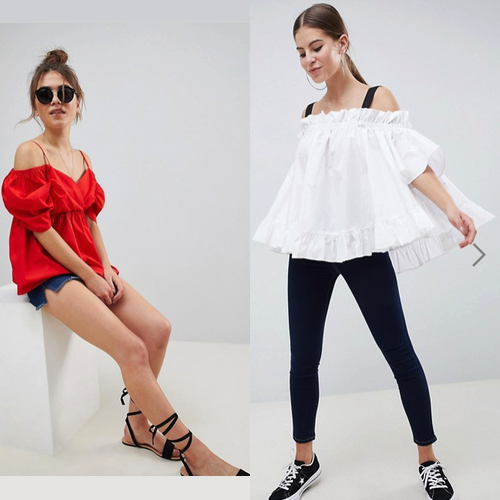

In [5]:
img_size = 500
img_paths = ['/content/asos.png','/content/asos1.png']

rgb_imgs, around, margins, trim_imgs, top_color,\
bottom_color,rates,x_shift,y_shift\
= [],[],[],[],[],[],[],[],[]
last_img = []

for i in range(len(img_paths)):
  around.append(get_around(img_paths[i]))
  rgb_imgs.append(open_rgb(img_paths[i]))
  trim_imgs.append(rgb_imgs[i].crop(around[i]))
  
  # find top and bottomo color
  top_color.append(get_median_color(rgb_imgs[i],around[i][1]))
  bottom_color.append(get_median_color(rgb_imgs[i],around[i][3]))
  

bg = make_background(top_color,bottom_color,img_size)

# resize
half_img_size = int(img_size/2)
for i in range(len(img_paths)):
  width = get_width(around[i])
  height = get_height(around[i])
  print('width:height',width,height)
  rate_x = half_img_size / width
  rate_y = img_size / height
  rate = rate_x if rate_x < rate_y else rate_y
  print('rate',rate)
  rates.append(rate)
  margins.append(np.array(around[i]) * rate)

  new_width = int(rgb_imgs[i].size[0]*rate_x)
  new_height = int(rgb_imgs[i].size[1]*rate_y)
  
  
  print('new_width:new_height',new_width,new_height)
  rgb_imgs[i].thumbnail((new_width,new_height), Image.ANTIALIAS)
  print('image{}:{}'.format(i,rgb_imgs[i].size))
  
  height = img_size - rgb_imgs[i].size[1]
  print('height',height)
  width = int(margins[i][0])
  print('width',width)
  
  if i == 0:
    margin = rgb_imgs[i].size[0] - half_img_size
    print('margin',margin)
    if margin < width : width = margin


    # cal image1 shift
    height = int(height / 2)
    if height<0:height = 0
    print('height',height)
  
  if i == 1:
    
    # cal image2 shift
    height = int(height / 2)
    if height<0:height = 0
    print(height)


    # make mask
    mask2 = Image.new("L", rgb_imgs[i].size, 0)
    draw2 = ImageDraw.Draw(mask2)
    right_max = half_img_size + rgb_imgs[i].size[0] - img_size
    print('right_max',right_max)
    if right_max < width:width = right_max
    draw2.rectangle((width, 0, rgb_imgs[i].size), fill=255)

  x_shift.append(width)
  y_shift.append(height)
  
  
# paste
bg.paste(rgb_imgs[0],(-x_shift[0],y_shift[0]))
bg.paste(rgb_imgs[1],(half_img_size - x_shift[1], y_shift[1]),mask2)
bg

# plt.imshow(bg)
# plt.plot()


In [0]:
!unzip test_image.zip

In [0]:
import os
for cur,dirs,files in os.walk('/content/test_image'):
  print(cur)
  print(dirs)
  print(files)